In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
boston = load_boston()

In [3]:
df = pd.DataFrame(boston.data,columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
x = boston.data
y = boston.target

### we need to convert it to Dmatrix for doing Model Training

In [5]:
data_matrix = xgb.DMatrix(data= x,label = y)
data_matrix

In [6]:
trainx,testx,trainy,testy = train_test_split(x,y,random_state=0)

In [7]:
xreg = xgb.XGBRegressor(learning_rate=.1,max_depth=5,n_estimators=10)
xreg.fit(trainx,trainy)
ypred=xreg.predict(testx)
rmse = np.sqrt(mean_squared_error(testy,ypred))
rmse

9.777224181641056

In [8]:
params = {
    'learning_rate':.1,
    'max_depth':5,
    'alpha':.5
}

In [9]:
result = xgb.cv(dtrain= data_matrix,
                params= params,
                nfold = 3,
                num_boost_round=100,
                early_stopping_rounds=10,
                metrics='rmse',
                seed = 0 )
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.616619,0.303411,21.635874,0.671068
1,19.587602,0.277160,19.626687,0.646785
2,17.757449,0.250927,17.814894,0.612731
3,16.103320,0.224683,16.197803,0.588456
4,14.614581,0.204207,14.746067,0.562735
...,...,...,...,...
95,0.584155,0.049964,3.767220,0.418035
96,0.576827,0.050399,3.766854,0.418206
97,0.571370,0.049767,3.766755,0.418596
98,0.564301,0.048055,3.765382,0.419699


<AxesSubplot:>

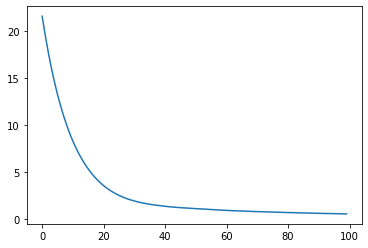

In [10]:
result['train-rmse-mean'].plot()

# hyperparameter tuning in xgboost
### to find the best parameter for the algorithm we will use gridsearch

In [14]:
gridsearch_params = [
    (max_depth,min_child_weight,learning_rate,subsample,colsample_bytree)
    for max_depth in  range(3,12)
    for min_child_weight in range(5,10)
    for learning_rate in np.arange(.1,1,.05)
    for subsample in np.arange(.1,1)
    for colsample_bytree in np.arange(.1,1)
]

In [15]:
from tqdm import tqdm

In [16]:
# initial parameter for variable
min_rmse = float('inf')
best_params = None
for max_depth,min_child_weight,lr,ss,cs_bytree in tqdm(gridsearch_params):
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['learning_rate'] = lr
    params['subsample'] = ss
    params['colsample_bytree'] = cs_bytree
    result = xgb.cv(dtrain= data_matrix,
                    params= params,
                    nfold = 5,
                    num_boost_round=100,
                    early_stopping_rounds=10,
                    metrics='rmse',
                    seed = 0 )
    mean_rmse = result['test-rmse-mean'].min()
    boost_rounds = result['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight,lr,ss,cs_bytree)
print(f'Best Params: {best_params[0]},{best_params[1]},{best_params[2]},{best_params[3]},{best_params[4]} with rmse: {min_rmse}')

100%|██████████| 810/810 [01:57<00:00,  6.88it/s]Best Params: 3,5,0.25000000000000006,0.1,0.1 with rmse: 4.6239364



In [14]:
params['max_depth'] = 4
params['min_child_weight'] = 7
params['learning_rate'] = 0.15
params['alpha'] = .5
params

{'learning_rate': 0.15, 'max_depth': 4, 'alpha': 0.5, 'min_child_weight': 7}

## model training

In [15]:
trainx,testx,trainy,testy = train_test_split(x,y,test_size=.2,random_state=0)
dtrain = xgb.DMatrix(data=trainx,label=trainy)
dtest = xgb.DMatrix(data=testx,label=testy)

In [16]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round = 100,
    evals=[(dtest,'Test')],
    early_stopping_rounds=10
)

[0]	Test-rmse:20.26882
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:17.51834
[2]	Test-rmse:15.16920
[3]	Test-rmse:13.24647
[4]	Test-rmse:11.61087
[5]	Test-rmse:10.25640
[6]	Test-rmse:9.20160
[7]	Test-rmse:8.31116
[8]	Test-rmse:7.57763
[9]	Test-rmse:7.02559
[10]	Test-rmse:6.61641
[11]	Test-rmse:6.26306
[12]	Test-rmse:5.93847
[13]	Test-rmse:5.74773
[14]	Test-rmse:5.57630
[15]	Test-rmse:5.46043
[16]	Test-rmse:5.37922
[17]	Test-rmse:5.32826
[18]	Test-rmse:5.27910
[19]	Test-rmse:5.15989
[20]	Test-rmse:5.13882
[21]	Test-rmse:5.12583
[22]	Test-rmse:5.06174
[23]	Test-rmse:5.06877
[24]	Test-rmse:5.04505
[25]	Test-rmse:4.96298
[26]	Test-rmse:4.96728
[27]	Test-rmse:4.95127
[28]	Test-rmse:4.94864
[29]	Test-rmse:4.93313
[30]	Test-rmse:4.89716
[31]	Test-rmse:4.87823
[32]	Test-rmse:4.87322
[33]	Test-rmse:4.84334
[34]	Test-rmse:4.82127
[35]	Test-rmse:4.80808
[36]	Test-rmse:4.80999
[37]	Test-rmse:4.81696
[38]	Test-rmse:4.82491
[39]	Test-rmse:4.81899
[40]	Test-rmse:4.79839
[41]

## model saving

In [17]:
num_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round= num_round,
    evals = [(dtest,'Test')]
)

[0]	Test-rmse:20.26882
[1]	Test-rmse:17.51834
[2]	Test-rmse:15.16920
[3]	Test-rmse:13.24647
[4]	Test-rmse:11.61087
[5]	Test-rmse:10.25640
[6]	Test-rmse:9.20160
[7]	Test-rmse:8.31116
[8]	Test-rmse:7.57763
[9]	Test-rmse:7.02559
[10]	Test-rmse:6.61641
[11]	Test-rmse:6.26306
[12]	Test-rmse:5.93847
[13]	Test-rmse:5.74773
[14]	Test-rmse:5.57630
[15]	Test-rmse:5.46043
[16]	Test-rmse:5.37922
[17]	Test-rmse:5.32826
[18]	Test-rmse:5.27910
[19]	Test-rmse:5.15989
[20]	Test-rmse:5.13882
[21]	Test-rmse:5.12583
[22]	Test-rmse:5.06174
[23]	Test-rmse:5.06877
[24]	Test-rmse:5.04505
[25]	Test-rmse:4.96298
[26]	Test-rmse:4.96728
[27]	Test-rmse:4.95127
[28]	Test-rmse:4.94864
[29]	Test-rmse:4.93313
[30]	Test-rmse:4.89716
[31]	Test-rmse:4.87823
[32]	Test-rmse:4.87322
[33]	Test-rmse:4.84334
[34]	Test-rmse:4.82127
[35]	Test-rmse:4.80808
[36]	Test-rmse:4.80999
[37]	Test-rmse:4.81696
[38]	Test-rmse:4.82491
[39]	Test-rmse:4.81899
[40]	Test-rmse:4.79839
[41]	Test-rmse:4.78949
[42]	Test-rmse:4.79889
[43]	Test-rmse:

In [18]:
pred = best_model.predict(dtest)
np.sqrt(mean_squared_error(testy,pred))

4.650862951909819